In [110]:
import os
import numpy as np
from plot_params import *
from scipy.spatial.distance import cdist
from copy import deepcopy
from tqdm import tqdm
from joblib import Parallel, delayed
from matplotlib.animation import FuncAnimation

In [111]:
"""
Points for in discussion
- extend to 3d
- reannealing
- other methods of solving, like genetic algorithm

"""

'\nPoints for in discussion\n- extend to 3d\n- reannealing\n- other methods of solving, like genetic algorithm\n\n'

In [112]:
"""
TODO: 
- Different cooling schedules
- Decrease stepsize

Figures:
- Examples using both cooling schemes with n = 12, 30, 56, include the variability
- 
"""

'\nTODO: \n- Different cooling schedules\n- Decrease stepsize\n\nFigures:\n- Examples using both cooling schemes with n = 12, 30, 56, include the variability\n- \n'

In [113]:
class RunSimulation():
    def __init__(
        self, 
        n_charges, 
        circle_radius, 
        n_steps, 
        stepsize_init, 
        stepsize_final, 
        random_influence, 
        force_influence, 
        cooling_function
    ):
        self.n_charges = n_charges
        self.circle_radius = circle_radius
        self.n_steps  = n_steps
        self.stepsize_init = stepsize_init
        self.stepsize_final = stepsize_final
        self.random_influence = random_influence
        self.force_influence = force_influence
        self.cooling_function = cooling_function
    
         # initialize charges
        r = np.random.rand(n_charges) * 0.1
        theta = np.random.rand(n_charges) * 2 * np.pi
        x = np.cos(theta) * r
        y = np.sin(theta) * r
        self.pos = np.stack((x, y), axis=1)

        # initialize loop arrays
        self.pos_history = np.zeros((n_steps, n_charges, 2))
        self.stepsize = np.linspace(stepsize_init, stepsize_final, n_steps)
        self.temperature = cooling_function(n_steps)
  

    def run(self):
        # loop over temperatures
        for j in tqdm(range(self.n_steps)):
            self.pos_history[j] = self.pos

            # loop charge
            for i in range(self.n_charges):
                energy_before = self.total_energy(self.pos)
                possible_pos = self.random_move_with_drift(deepcopy(self.pos), i, j)
                energy_after = self.total_energy(possible_pos)
                if self.accept_move(energy_after, energy_before, j):
                    self.pos = possible_pos

        return self.pos

    def total_energy(self, pos):
        dist = cdist(pos, pos)
        return (1 / dist[dist != 0]).sum() / 2


    def accept_move(self, energy_after, energy_before, j):
        delta_energy = energy_after - energy_before
        if delta_energy < 0:
            return True
        alpha = np.exp(- delta_energy / self.temperature[j]) 
        if np.random.rand() <= alpha:
            return True
        return False

    def get_force(self, pos, i):
        # total distance to charge i
        r = cdist(pos, pos)
        r = r[i]
        r = r[r != 0]

        # x distance
        r_x = pos[:, 0].reshape(-1 , 1) - pos[:, 0]
        r_x = r_x[i]
        r_x = r_x[r_x != 0]

        # y distance
        r_y = pos[:, 1].reshape(-1 , 1) - pos[:, 1]
        r_y = r_y[i]
        r_y = r_y[r_y != 0]

        # total force 
        force = np.stack((r_x / np.abs(r ** 3), r_y / np.abs(r ** 3)), axis=1)
        total_force = force.sum(axis=0)

        # normalized size 1
        normal_force_move = total_force / np.linalg.norm(total_force)

        return normal_force_move


    def get_random(self):
        random_move = np.random.uniform(-1, 1, 2)
        normal_random_move = random_move / np.linalg.norm(random_move)
        return normal_random_move


    def get_step(self, normal_force_move, normal_random_move, j):
        combined_step = (normal_random_move * self.random_influence 
                      + normal_force_move * self.force_influence)
        normal_step =  combined_step / np.linalg.norm(combined_step)
        step =  normal_step * self.stepsize[j]
        return step
    
    def move_across_circle(self, pos, i, step):
        # if not, move across the circle edge
        step_size = np.linalg.norm(step)
        dist_to_circle = circle_radius - np.sqrt(pos[i, :][0] ** 2 + pos[i, :][1] ** 2)
        step_angle = np.arctan2(step[1], step[0])
        point_angle = np.arctan2(pos[i, 1], pos[i, 0])
        angle_dif = step_angle - point_angle
        arc_length = step_size - dist_to_circle
        arc_angle = np.copysign(arc_length / self.circle_radius,angle_dif)
        pos[i, 0] = np.cos(point_angle+arc_angle) * self.circle_radius
        pos[i, 1] = np.sin(point_angle+arc_angle) * self.circle_radius
        return pos

    def random_move_with_drift(self, pos, i, j):
        og = deepcopy(pos)

        normal_force_move = self.get_force(pos, i)
        normal_random_move = self.get_random()
        step = self.get_step(normal_force_move, normal_random_move, j)
        pos[i] = og[i] + step
        
        # check if outside of circle
        if np.sqrt(pos[i][0] ** 2 + pos[i][1] ** 2) < self.circle_radius:
            return pos
        return self.move_across_circle(pos, i, step)


In [114]:
class PostProcess():
    def __init__(self, best_runs, best_of_best_index=None):
        self.best_runs = best_runs
        self.best_of_best_index = best_of_best_index

    
    def make_figure(self, savepath):
        standard_pos = self.best_runs[self.best_of_best_index]
        best_runs_without_best = np.delete(self.best_runs, self.best_of_best_index, axis=0)
        plt.figure(figsize=(6, 6))
        for br in best_runs_without_best:
            plot_br = self.get_minimized_config(standard_pos, br)
            plt.scatter(plot_br[:, 0], plot_br[:, 1], color='tab:blue', edgecolors='darkslategray')
        plt.scatter(standard_pos[:, 0], standard_pos[:, 1], s=400, zorder=-100, color='tab:orange', edgecolors='saddlebrown')
        circle = plt.Circle((0, 0), 1, fill=False)
        plt.gca().add_patch(circle)
        plt.yticks(np.linspace(-1, 1, 5))
        plt.tight_layout()
        if savepath:
            plt.savefig(savepath)
        plt.show()
    
    def variability_score(self):
        
        scores_mean = np.zeros((len(self.best_runs)))
        for i, br in enumerate(self.best_runs):
            optimized_configs = [self.get_minimized_config(br, i) for i in self.best_runs]
            difference_scores = [self.difference_score(0, br, i) for i in optimized_configs]
            scores_mean[i] = np.mean(difference_scores)
        score = scores_mean.mean()
        return score
    
    def difference_score(self, theta_rotation, standard_pos, pos):
        pos = self.rotation(pos, theta_rotation)
        return cdist(standard_pos, pos).min(axis=1).sum()

    def get_minimized_config(self, standard_pos, pos, precision=1000):
        radians = np.linspace(0, 2 * np.pi, precision)
        scores = [self.difference_score(r, standard_pos, pos) for r in radians]
        best_radian = radians[np.argmin(scores)]
        return self.rotation(pos, best_radian)   
    
    def rotation(self, pos, theta_rotation):
        x = pos[:, 0]
        y = pos[:, 1]
        r = np.sqrt(x ** 2 + y ** 2)
        theta = np.arctan2(y, x)
        theta = theta + theta_rotation
        x = np.cos(theta) * r
        y = np.sin(theta) * r
        pos = np.stack((x, y), axis=1)
        return pos

In [115]:
class CircleCharges():
    def __init__(
        self, 
        n_charges, 
        n_attemps_per_run, 
        n_runs, 
        circle_radius, 
        n_steps, 
        stepsize_init, 
        stepsize_final, 
        random_influence, 
        force_influence, 
        cooling_function
    ):

        self.n_charges = n_charges
        self.n_attemps_per_run = n_attemps_per_run
        self.n_runs = n_runs
        self.circle_radius = circle_radius
        self.n_steps  = n_steps
        self.stepsize_init = stepsize_init
        self.stepsize_final = stepsize_final
        self.random_influence = random_influence
        self.force_influence = force_influence
        self.cooling_function = cooling_function

        self.best_runs = np.zeros((self.n_runs, self.n_charges, 2))


    def produce_figure(self, savepath=None):
        best_of_best_index = self.choose_best_run(self.best_runs)[1]
        pp = PostProcess(self.best_runs, best_of_best_index)
        pp.make_figure(savepath)
        pass

    def get_variability_score(self):
        pp = PostProcess(self.best_runs)
        score = pp.variability_score()
        return score

    def run(self):
        for i in tqdm(range(self.n_runs)):
            many_attemps = (
                Parallel(n_jobs=-1, verbose=0)
                (delayed(self.single_run)
                () for _ in range(self.n_attemps_per_run))
            )
            many_attemps = np.array(many_attemps)
            best = self.choose_best_run(many_attemps)[0]
            self.best_runs[i] = best
        
    def total_energy(self, pos):
        dist = cdist(pos, pos)
        return (1 / dist[dist != 0]).sum() / 2

    def choose_best_run(self, runs):
        energies = np.zeros(len(runs))
        for i, r in enumerate(runs):
            e = self.total_energy(r)
            energies[i] = e
        index_best = np.argmin(energies)
        best = runs[index_best]
        return best, index_best

    def single_run(self):
        rs = RunSimulation(
            self.n_charges,
            self.circle_radius,
            self.n_steps, 
            self.stepsize_init,
            self.stepsize_final,
            self.random_influence, 
            self.force_influence,
            self.cooling_function
        )
        final_pos =  rs.run()
        return final_pos

100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


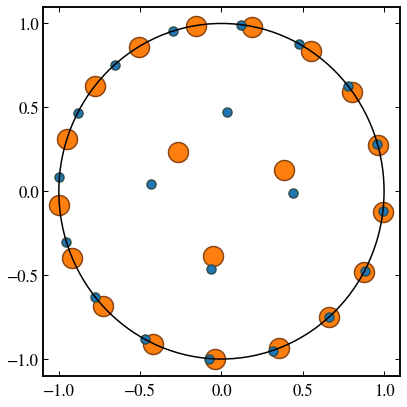

0.9802637651214985


In [116]:
# things the class should do:

# simulation setings
n_charges = 20
n_attemps_per_run = 1
n_runs = 2
circle_radius = 1

# simulation parameters
n_steps = 100
stepsize_init = 0.05
stepsize_final = 0.02
random_influence = 1
force_influence = 1

# parameters for exponential cooling function
cooling_function = 'exponential'

def cooling_logistic(steps):
    B = 7
    vu = 5
    M = 5
    i = np.linspace(10, 1, steps)
    T = 1 / (1 + np.exp(- B * (i - M)) ** (1 / vu)) 
    return T

cooling_function = cooling_logistic


# parameters for logistic cooling function

# initialize simulation
cc = CircleCharges(
    n_charges, 
    n_attemps_per_run, 
    n_runs, 
    circle_radius, 
    n_steps, 
    stepsize_init, 
    stepsize_final, 
    random_influence, 
    force_influence, 
    cooling_function
)

# run the simulation
cc.run()

# produce image 
cc.produce_figure()

# give score 
score = cc.get_variability_score()
print(score)

In [117]:
# rs = RunSimulation(
#     n_charges,
#     circle_radius,
#     n_steps, 
#     stepsize_init,
#     stepsize_final,
#     random_influence, 
#     force_influence,
#     cooling_function
# )
# final_pos = rs.run()


# frames = 50
# sec = 5
# pos_animate = rs.pos_history[::n_steps//frames]
# fig, ax = plt.subplots(figsize=(7, 7))
# plot = ax.scatter(pos_animate[0, :, 0], pos_animate[0, :, 1])
# text = ax.text(0.1, 0.9, '', fontsize=10)
# circle = plt.Circle((0, 0), 1, fill=False)
# plt.gca().add_patch(circle)
# ax.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))

# def anim_func(i):
#     plot.set_offsets(pos_animate[i])
#     text.set_text(f'{i}/{frames}')
#     return plot

# animation = FuncAnimation(fig, anim_func, frames=frames, interval=sec / frames * 1e3, save_count=frames)
# animation.save(f'kaas.mp4', dpi=100)